<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-pyresample-to-plot-channel-30-radiances" data-toc-modified-id="Use-pyresample-to-plot-channel-30-radiances-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use pyresample to plot channel 30 radiances</a></span></li><li><span><a href="#Read-the-projection-details-and-data" data-toc-modified-id="Read-the-projection-details-and-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read the projection details and data</a></span></li><li><span><a href="#get-the-map-projection-from-a301.geometry.get_proj_params" data-toc-modified-id="get-the-map-projection-from-a301.geometry.get_proj_params-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>get the map projection from a301.geometry.get_proj_params</a></span></li><li><span><a href="#Use-pyresample-to-define-a-new-grid-in-this-projection" data-toc-modified-id="Use-pyresample-to-define-a-new-grid-in-this-projection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Use pyresample to define a new grid in this projection</a></span></li><li><span><a href="#resample-ch30-on-this-grid" data-toc-modified-id="resample-ch30-on-this-grid-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>resample ch30 on this grid</a></span></li><li><span><a href="#replace-missing-values-with-floating-point-nan" data-toc-modified-id="replace-missing-values-with-floating-point-nan-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>replace missing values with floating point nan</a></span></li><li><span><a href="#Plot-the-image-using-cartopy" data-toc-modified-id="Plot-the-image-using-cartopy-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot the image using cartopy</a></span><ul class="toc-item"><li><span><a href="#Create-a-palette" data-toc-modified-id="Create-a-palette-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Create a palette</a></span></li></ul></li><li><span><a href="#write-out-all-the-projection-information-as-a-json-file" data-toc-modified-id="write-out-all-the-projection-information-as-a-json-file-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>write out all the projection information as a json file</a></span></li></ul></div>

# Use pyresample to plot channel 30 radiances

This notebook uses a MYD03 file and a modis_chans.hdf file to resample the channel 30 radiance
from your granule onto a laea projection.

The two files are copied to new files below called generic_m3 and generic_rad,
so that this notebook works for all granules.

In [1]:
import a301
import json
from a301.utils.data_read import download
import a301
import pprint
import shutil
from pyhdf.SD import SD, SDC
import json
import pprint
import cartopy
from pyresample import kd_tree
from a301.scripts.modismeta_read import parseMeta


In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from pathlib import Path
import pprint
import numpy as np
import pdb
import shutil
import a301
#

# Read the projection details and data



In [3]:
generic_rad = a301.data_dir / Path('rad_file_2018_10_1.hdf')
generic_m3 = a301.data_dir / Path('m3_file_2018_10_1.hdf')
m3_metadata=parseMeta(generic_m3)

In [4]:
# Read the lats and lons from the MYD03 file
print(f'reading {generic_m3}')
m3_file = SD(str(generic_m3), SDC.READ)
lats = m3_file.select('Latitude').get()
lons = m3_file.select('Longitude').get()
m3_file.end()

reading C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\m3_file_2018_10_1.hdf


In [5]:
#Read ch30 from the generic_rad file
rad_file = SD(str(generic_rad), SDC.READ)
ch30 = rad_file.select('ch30').get()
rad_file.end()

# get the map projection from a301.geometry.get_proj_params

pyresample needs proj4 map parameters to put together its grid.  These are
returned by the get_proj_params file below.  It is available in version 0.0.5 of the a301 library.

In [6]:
def get_proj_params(modis_file):
    """
    given a path to a Modis level1b file with a standard
    'CoreMetadata.0' atrribute, return proj4 parameters
    for use by cartopy or pyresample, assuming a laea projection
    and WGS84 datum
    
    Parameters
    ----------
    
    modis_file:  Path or str with path to hdf file
    
    Returns
    -------
    
    proj_params: dict
        dict with parameters for proj4
        
    """
    modis_dict=parseMeta(modis_file)
    import cartopy.crs as ccrs
    globe_w = ccrs.Globe(datum="WGS84",ellipse="WGS84")
    projection_w=ccrs.LambertAzimuthalEqualArea(central_latitude=modis_dict['lat_0'],
                    central_longitude= modis_dict['lon_0'],globe=globe_w)
    proj_params=projection_w.proj4_params
    return proj_params  

In [7]:
from a301.geometry import get_proj_params
get_proj_params(generic_m3)

{'datum': 'WGS84',
 'ellps': 'WGS84',
 'proj': 'laea',
 'lon_0': 15.790092241360691,
 'lat_0': 44.06927955017845,
 'x_0': 0.0,
 'y_0': 0.0}

# Use pyresample to define a new grid in this projection

In [8]:
from pyresample import load_area, save_quicklook, SwathDefinition
proj_params = get_proj_params(generic_m3)
swath_def = SwathDefinition(lons, lats)
area_def=swath_def.compute_optimal_bb_area(proj_dict=proj_params)

In [9]:
area_def

Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'ellps': 'WGS84', 'lat_0': '44.06927955017845', 'lon_0': '15.790092241360691', 'proj': 'laea', 'x_0': '0.0', 'y_0': '0.0'}
Number of columns: 1489
Number of rows: 2233
Area extent: (-1264819.272413685, -1183374.832991477, 1563143.3917710609, 1288009.1408023185)

# resample ch30 on this grid

In [10]:
fill_value=-9999.
area_name = 'modis swath 5min granule'
image_30 = kd_tree.resample_nearest(swath_def, ch30.ravel(),
                                  area_def, radius_of_influence=5000, 
                                      nprocs=2,fill_value=fill_value)
print(f'\ndump area definition:\n{area_def}\n')
print((f'\nx and y pixel dimensions in meters:'
       f'\n{area_def.pixel_size_x}\n{area_def.pixel_size_y}\n'))


dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'ellps': 'WGS84', 'lat_0': '44.06927955017845', 'lon_0': '15.790092241360691', 'proj': 'laea', 'x_0': '0.0', 'y_0': '0.0'}
Number of columns: 1489
Number of rows: 2233
Area extent: (-1264819.272413685, -1183374.832991477, 1563143.3917710609, 1288009.1408023185)


x and y pixel dimensions in meters:
1899.2361747379086
1106.7550263295097



# replace missing values with floating point nan

In [11]:
nan_value = np.array([np.nan],dtype=np.float32)[0]
image_30[image_30< -9000]=nan_value

# Plot the image using cartopy

## Create a palette

We want to spread the colors over a limited range of values between 0.1 and 7 W/m^2/microns/sr so we
will set over and under colors and normalize the data to this range

 Some links about colors:
 
* [rods, cones and rgb](https://theneurosphere.com/2015/12/17/the-mystery-of-tetrachromacy-if-12-of-women-have-four-cone-types-in-their-eyes-why-do-so-few-of-them-actually-see-more-colours/)

* [matplotlib palettes](https://matplotlib.org/examples/color/colormaps_reference.html)
 
* [xkcd color survey](https://blog.xkcd.com/2010/05/03/color-survey-results/)
 
* [xkcd colors from matplotlib](https://seaborn.pydata.org/generated/seaborn.xkcd_palette.html)
 
* [wikipedia article on RGB colors](https://en.wikipedia.org/wiki/RGB_color_model)


In [12]:
pal = plt.get_cmap('plasma')
pal.set_bad('0.75') #75% grey for out-of-map cells
pal.set_over('r')  #color cells > vmax red
pal.set_under('k')  #color cells < vmin black
vmin= 0.1
vmax= 7.0
from matplotlib.colors import Normalize
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

In [13]:
## use the palette on the image_30 array

C:\Users\Pearl\Anaconda3\lib\site-packages\pyresample\_cartopy.py:36: UserWarning: 'cartopy' >= 0.17 required for better 'from_proj' functionality.
  warnings.warn("'cartopy' >= 0.17 required for better 'from_proj' "


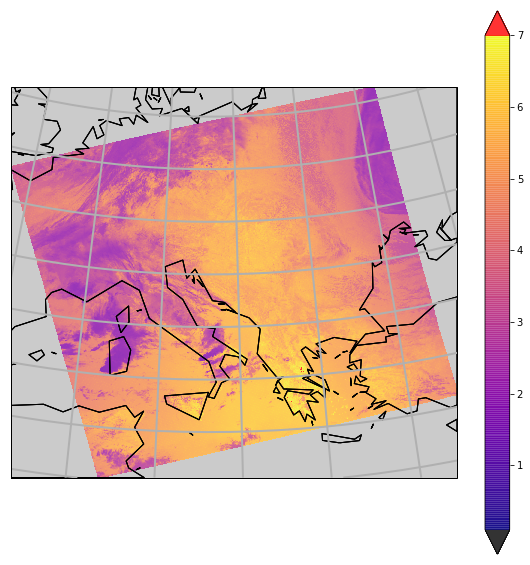

In [14]:
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(1, 1, figsize=(10,10),
                          subplot_kw={'projection': crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));
ax.set_extent(crs.bounds,crs)
cs=ax.imshow(image_30, transform=crs, extent=crs.bounds, 
             origin='upper',alpha=0.8,cmap=pal,norm=the_norm)
fig.colorbar(cs,extend='both');

# write out all the projection information as a json file

Make a new folder to hold this, along with the resampled image written as
a [numpy npz file](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html)

In that folder, also write out a json file with all the metadata

In [15]:
out_dict={}
out_dict['proj_params']=crs.proj4_params
out_dict['extent']=crs.bounds
globe=crs.globe.to_proj4_params()
out_dict['globe']=dict(globe)
m3_metadata['lon_list']=list(m3_metadata['lon_list'])
m3_metadata['lat_list']=list(m3_metadata['lat_list'])
out_dict['metadata']=m3_metadata
out_dict['field_name']="ch30"
out_dict['units']="W/m^2/sr/micron"
out_dict['variable_description']="channel 30 radiance"
out_dict['x_size']=area_def.x_size
out_dict['y_size']=area_def.y_size
out_dir_name="ch30_resample"
out_dict['out_dir']=out_dir_name
out_dir = a301.data_dir.parent / Path('test_data') / Path(out_dir_name)
out_dir.mkdir(parents=True, exist_ok=True)
image_name= out_dir / Path(f"{out_dir_name}.npz")
json_name = out_dir /Path(f"{out_dir_name}.json")
np.savez(image_name,ch30_resample=image_30)
with open(json_name,'w') as f:
    json.dump(out_dict,f,indent=4)

